# This dataset contains information on historic trades for several cryptoassets, such as Bitcoin and Ethereum. Your challenge is to predict their future returns.

As historic cryptocurrency prices are not confidential this will be a forecasting competition using the time series API. Furthermore the public leaderboard targets are publicly available and are provided as part of the competition dataset. Expect to see many people submitting perfect submissions for fun. Accordingly, THE PUBLIC LEADERBOARD FOR THIS COMPETITION IS NOT MEANINGFUL and is only provided as a convenience for anyone who wants to test their code. The final private leaderboard will be determined using real market data gathered after the submission period closes.

train.csv - The training set

- timestamp - A timestamp for the minute covered by the row.
- Asset_ID - An ID code for the cryptoasset.
- Count - The number of trades that took place this minute.
- Open - The USD price at the beginning of the minute.
- High - The highest USD price during the minute.
- Low - The lowest USD price during the minute.
- Close - The USD price at the end of the minute.
- Volume - The number of cryptoasset u units traded during the minute.
- VWAP - The volume-weighted average price for the minute.
- Target - 15 minute residualized returns. See the 'Prediction and Evaluation section of this notebook for details of how the target is calculated.
- Weight - Weight, defined by the competition hosts here
- Asset_Name - Human readable Asset name.

example_test.csv - An example of the data that will be delivered by the time series API.

example_sample_submission.csv - An example of the data that will be delivered by the time series API. The data is just copied from train.csv.

asset_details.csv - Provides the real name and of the cryptoasset for each Asset_ID and the weight each cryptoasset receives in the metric.

supplemental_train.csv - After the submission period is over this file's data will be replaced with cryptoasset prices from the submission period. In the Evaluation phase, the train, train supplement, and test set will be contiguous in time, apart from any missing data. The current copy, which is just filled approximately the right amount of data from train.csv is provided as a placeholder.

    📌 There are 14 coins in the dataset

    📌 There are 4 years in the [full] dataset


#  Import

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

import time

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)

False


# Load data

In [3]:
pd.set_option('display.max_rows', None)
train_csv = pd.read_csv("train.csv")
test_csv = pd.read_csv("example_test.csv")
samples_submission_csv = pd.read_csv("example_sample_submission.csv")
asset_csv = pd.read_csv("asset_details.csv")
supplemental_train = pd.read_csv("supplemental_train.csv")

# Remove NaN rows

In [4]:
train_csv = train_csv.dropna()

In [5]:
train_csv.iloc[1:10]

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875
10,1514764920,1,235.0,13835.036000,14052.3000,13680.0000,13828.102000,31.046432,13840.362591,-0.015037


In [6]:
asset_csv

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [11]:
train_csv_BitcoinDash = train_csv[train_csv.Asset_ID==0]

In [15]:
len(train_csv_BitcoinDash)

1929204

# Target evolution visualization

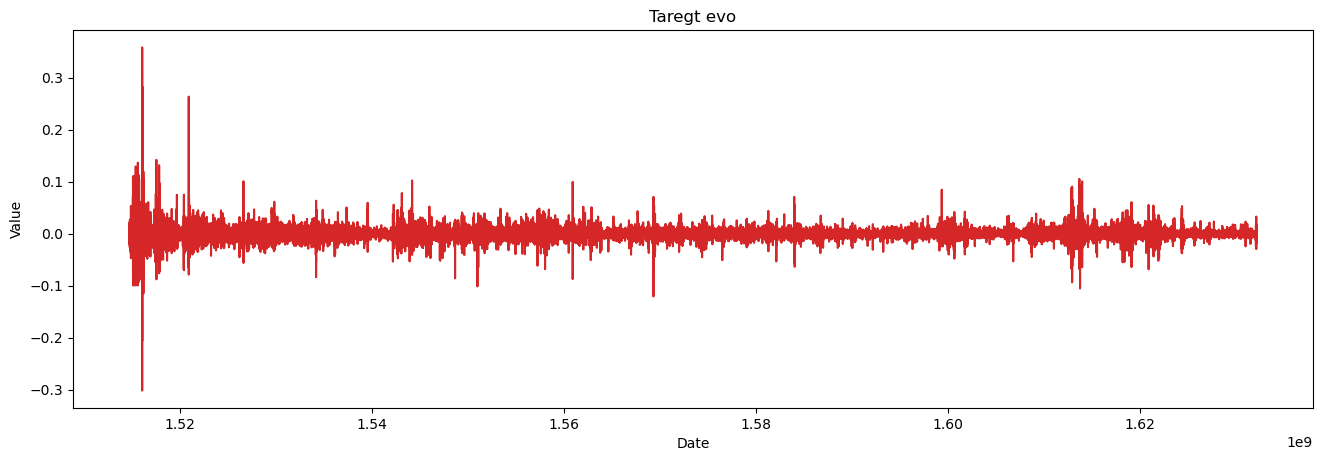

In [16]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(train_csv_BitcoinDash, x=train_csv_BitcoinDash.timestamp, y=train_csv_BitcoinDash.Target, title='Taregt evo')

# Memory review

In [7]:
train_csv.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486465 entries, 0 to 24236581
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.9 GB


# Memory Size Reduction

In [8]:
for column in train_csv:
    print(column)
    if train_csv[column].dtype == 'float64':
        train_csv[column]=pd.to_numeric(train_csv[column], downcast='float')
    if train_csv[column].dtype == 'int64':
        train_csv[column]=pd.to_numeric(train_csv[column], downcast='integer')

timestamp
Asset_ID
Count
Open
High
Low
Close
Volume
VWAP
Target


In [9]:
train_csv.info(memory_usage = "deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486465 entries, 0 to 24236581
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int32  
 1   Asset_ID   int8   
 2   Count      float32
 3   Open       float32
 4   High       float32
 5   Low        float32
 6   Close      float32
 7   Volume     float32
 8   VWAP       float32
 9   Target     float32
dtypes: float32(8), int32(1), int8(1)
memory usage: 1007.9 MB


# Dataset description

In [10]:
dtf_description_train = train_csv.describe()
dtf_description_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07,2.348646e+07
mean,1.577541e+09,6.224257e+00,2.954030e+02,1.476052e+03,1.479876e+03,1.472882e+03,1.476051e+03,2.947318e+05,NaN,7.121870e-06
std,3.333367e+07,4.099476e+00,8.796244e+02,6.119951e+03,6.129966e+03,6.110472e+03,6.119956e+03,2.471421e+06,NaN,5.679042e-03
min,1.514765e+09,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093510e-01
25%,1.549306e+09,3.000000e+00,2.200000e+01,2.808670e-01,2.819000e-01,2.800000e-01,2.808737e-01,1.493896e+02,2.808644e-01,-1.694353e-03
50%,1.578971e+09,6.000000e+00,6.900000e+01,1.486842e+01,1.489000e+01,1.484400e+01,1.486866e+01,1.332360e+03,1.486720e+01,-4.289820e-05
75%,1.606979e+09,9.000000e+00,2.310000e+02,2.349650e+02,2.353800e+02,2.345200e+02,2.349686e+02,2.911512e+04,2.349653e+02,1.601519e-03
max,1.632181e+09,1.300000e+01,1.650160e+05,6.480595e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


In [11]:
dtf_description_test = test_csv.describe()
dtf_description_test

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,group_num,row_id
count,5.600000e+01,56.00000,56.000000,56.000000,56.000000,56.000000,56.000000,5.600000e+01,56.000000,56.000000,56.000000
mean,1.623542e+09,6.50000,739.535714,3017.680422,3021.572698,3010.191113,3015.398331,4.440252e+05,3015.895414,1.500000,27.500000
std,6.768913e+01,4.06761,806.311917,9148.328623,9159.452237,9125.151477,9141.188374,1.027897e+06,9142.300540,1.128152,16.309506
min,1.623542e+09,0.00000,34.000000,0.068015,0.068055,0.067866,0.067936,1.187095e+00,0.067958,0.000000,0.000000
25%,1.623542e+09,3.00000,258.000000,1.002400,1.018800,0.983500,1.000538,6.911536e+02,1.000546,0.750000,13.750000
50%,1.623542e+09,6.50000,448.500000,108.591617,108.712000,108.226000,108.414840,2.494379e+03,108.447083,1.500000,27.500000
75%,1.623543e+09,10.00000,891.750000,580.817500,582.975000,579.692500,580.974167,2.965427e+05,581.061773,2.250000,41.250000
max,1.623543e+09,13.00000,3531.000000,35596.771429,35652.464650,35533.380000,35602.004286,4.981365e+06,35584.861196,3.000000,55.000000


In [12]:
dtf_description_sample = samples_submission_csv.describe()
dtf_description_sample

,group_num,row_id,Target
count,56.000000,56.000000,56.0
mean,1.500000,27.500000,0.0
std,1.128152,16.309506,0.0
min,0.000000,0.000000,0.0
25%,0.750000,13.750000,0.0
50%,1.500000,27.500000,0.0
75%,2.250000,41.250000,0.0
max,3.000000,55.000000,0.0


In [13]:
dtf_description_asset = asset_csv.describe()
dtf_description_asset

,Asset_ID,Weight
count,14.0000,14.000000
mean,6.5000,2.919989
std,4.1833,1.801957
min,0.0000,1.098612
25%,3.2500,1.655018
50%,6.5000,2.238668
75%,9.7500,4.116886
max,13.0000,6.779922


In [14]:
dtf_supplemental_train= supplemental_train.describe()
dtf_supplemental_train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.015112e+06,2.015112e+06,2.015112e+06,2.015112e+06,2.015112e+06,2.015112e+06,2.015112e+06,2.015112e+06,2.015112e+06,2.013377e+06
mean,1.627863e+09,6.499139e+00,5.163656e+02,3.408915e+03,3.412519e+03,3.405373e+03,3.408919e+03,3.386617e+05,3.408879e+03,2.409469e-06
std,2.494254e+06,4.031342e+00,1.060273e+03,1.052321e+04,1.053392e+04,1.051262e+04,1.052323e+04,1.387742e+06,1.052310e+04,4.333439e-03
min,1.623542e+09,0.000000e+00,1.000000e+00,4.652540e-02,4.695000e-02,4.637000e-02,4.652140e-02,9.610000e-06,4.654178e-02,-7.880525e-02
25%,1.625702e+09,3.000000e+00,8.200000e+01,9.160500e-01,9.381000e-01,8.970000e-01,9.160000e-01,1.457512e+02,9.159005e-01,-1.380767e-03
50%,1.627864e+09,6.000000e+00,2.010000e+02,7.554037e+01,7.578950e+01,7.535660e+01,7.553027e+01,1.352555e+03,7.553674e+01,-6.469021e-05
75%,1.630023e+09,1.000000e+01,5.390000e+02,5.637334e+02,5.642800e+02,5.631500e+02,5.637578e+02,1.021959e+05,5.637045e+02,1.251661e-03
max,1.632182e+09,1.300000e+01,8.747800e+04,5.288442e+04,5.295647e+04,5.285604e+04,5.288209e+04,1.261933e+08,5.289832e+04,2.112271e-01


# Do not Run

train_csv otherwise the kernel will die

# Number of entries that are null/void

In [15]:
def list_null(dataset, feature, per):
    # Input
    # dataset: the selected dataset
    # feature: the name of the feature
    # per: the percentage of row that are void vs the whole column
    # output
    # list the column with a void percentage higher than per
    res = []
    for f in feature:
        #print("feature: {} number of missing value: {} \n the lengt of the dataset is {} and the percentage of null value is {}".format(f, train_csv[f].isna().sum(), len(dataset), train_csv[f].isna().sum()/len(dataset)))
        if (dataset[f].isna().sum()/len(dataset)) > per:
            res.append(f)
        
    return res

list_null(train_csv, train_csv.columns, 0.001)


[]

# Distribution info

In [16]:
'''y = train_csv_nnan['Target']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=stats.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=stats.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=stats.lognorm)'''

# Note: output is highly concentrated around 0

"y = train_csv_nnan['Target']\nplt.figure(1); plt.title('Johnson SU')\nsns.distplot(y, kde=False, fit=stats.johnsonsu)\nplt.figure(2); plt.title('Normal')\nsns.distplot(y, kde=False, fit=stats.norm)\nplt.figure(3); plt.title('Log Normal')\nsns.distplot(y, kde=False, fit=stats.lognorm)"

# Datashowcase

In [17]:
train_csv.Target[0:9]

0   -0.004218
1   -0.014399
2   -0.014643
3   -0.013922
4   -0.008264
5   -0.004809
6   -0.009791
8   -0.004079
9   -0.015875
Name: Target, dtype: float32

AttributeError: 'DataFrame' object has no attribute 'value'

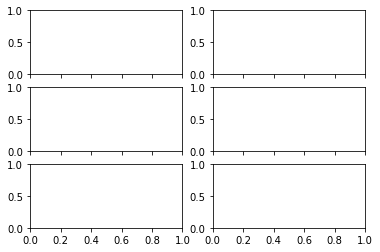

In [21]:
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(train_csv.value)
axes[0,0].set_title('Original Series')
plot_acf(train_csv.value, ax=axes[0, 1])

# Dataset preparation

In [32]:
class TimeSeriesDataset (Dataset):
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len
    
    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)
    
    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

# Dataloader

In [36]:
train_dataset = TimeSeriesDataset(X, target, seq_len=100)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 50, shuffle = False)

for i, d in enumerate(train_dataloader):
    print(i, d[0].shape, d[1].shape)

NameError: name 'X' is not defined

# Define the RNN

Next, we define an RNN in PyTorch. We'll use `nn.RNN` to create an RNN layer, then we'll add a last, fully-connected layer to get the output size that we want. An RNN takes in a number of parameters:
* **input_size** - the size of the input
* **hidden_dim** - the number of features in the RNN output and in the hidden state
* **n_layers** - the number of layers that make up the RNN, typically 1-3; greater than 1 means that you'll create a stacked RNN
* **batch_first** - whether or not the input/output of the RNN will have the batch_size as the first dimension (batch_size, seq_length, hidden_dim)

Take a look at the [RNN documentation](https://pytorch.org/docs/stable/nn.html#rnn) to read more about recurrent layers.

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()
        
        self.hidden_dim=hidden_dim

        # define an RNN with specified parameters
        # batch_first means that the first dim of the input and output will be the batch_size
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        # last, fully-connected layer
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        # x (batch_size, seq_length, input_size)
        # hidden (n_layers, batch_size, hidden_dim)
        # r_out (batch_size, time_step, hidden_size)
        batch_size = x.size(0)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)
        # shape output to be (batch_size*seq_length, hidden_dim)
        r_out = r_out.view(-1, self.hidden_dim)  
        
        # get final output 
        output = self.fc(r_out)
        
        return output, hidden

### Check the input and output dimensions

As a check that your model is working as expected, test out how it responds to input data.

In [ ]:
# test that dimensions are as expected
test_rnn = RNN(input_size=1, output_size=1, hidden_dim=10, n_layers=2)

# generate evenly spaced, test data pts
''' time_steps = np.linspace(0, np.pi, seq_length)
data = np.sin(time_steps)
data.resize((seq_length, 1))'''

test_input = torch.Tensor(data).unsqueeze(0) # give it a batch_size of 1 as first dimension
print('Input size: ', test_input.size())

# test out rnn sizes
test_out, test_h = test_rnn(test_input, None)
print('Output size: ', test_out.size())
print('Hidden state size: ', test_h.size())

# Training the RNN

In [ ]:
# decide on hyperparameters
input_size=1 
output_size=1
hidden_dim=32
n_layers=1

# instantiate an RNN
rnn = RNN(input_size, output_size, hidden_dim, n_layers)
print(rnn)

### Loss and Optimization

This is a regression problem: can we train an RNN to accurately predict the next data point, given a current data point?

>* The data points are coordinate values, so to compare a predicted and ground_truth point, we'll use a regression loss: the mean squared error.
* It's typical to use an Adam optimizer for recurrent models.

In [ ]:
# MSE loss and Adam optimizer with a learning rate of 0.01
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01) 

### Defining the training function

This function takes in an rnn, a number of steps to train for, and returns a trained rnn. This function is also responsible for displaying the loss and the predictions, every so often.

#### Hidden State

Pay close attention to the hidden state, here:
* Before looping over a batch of training data, the hidden state is initialized
* After a new hidden state is generated by the rnn, we get the latest hidden state, and use that as input to the rnn for the following steps

In [ ]:
# train the RNN
def train(rnn, n_steps, print_every):
    
    # initialize the hidden state
    hidden = None      
    
    for batch_i, step in enumerate(range(n_steps)):
        # defining the training data 
        time_steps = np.linspace(step * np.pi, (step+1)*np.pi, seq_length + 1)
        data = np.sin(time_steps)
        data.resize((seq_length + 1, 1)) # input_size=1

        x = data[:-1]
        y = data[1:]
        
        # convert data into Tensors
        x_tensor = torch.Tensor(x).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(y)

        # outputs from the rnn
        prediction, hidden = rnn(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data

        # calculate the loss
        loss = criterion(prediction, y_tensor)
        # zero gradients
        optimizer.zero_grad()
        # perform backprop and update weights
        loss.backward()
        optimizer.step()

        # display loss and predictions
        if batch_i%print_every == 0:        
            print('Loss: ', loss.item())
            plt.plot(time_steps[1:], x, 'r.') # input
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(), 'b.') # predictions
            plt.show()
    
    return rnn
